In [2]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch
import copy
import pandas as pd

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

from gsnn.models.GSNN import GSNN

from sklearn.metrics import r2_score

from gsnn.optim.InputEdgeInferrer import InputEdgeInferrer


# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Estimating input errors to infer novel input edges 

1. esimtate error using gradient descent on a trainable input edge parameter 
2. identify correlations between edge errors and input channels 

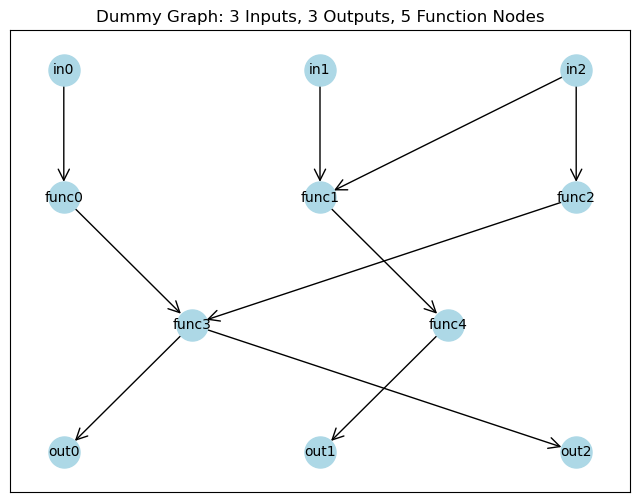

In [3]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2'), ('in2', 'func1')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [17]:
special_functions = {'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
                     'func0': lambda x: np.mean(([(xx-1)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)}

special_functions = None

x_train, x_test, y_train, y_test = simulate(G, n_train=25, n_test=100, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions, noise_scale=0.15)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [18]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# simulate a missing edge (in2, func1)
edge_index_dict_TRUE = copy.deepcopy(data.edge_index_dict)

edge_index_dict = copy.deepcopy(data.edge_index_dict)

edge_index_dict['input', 'to', 'function'] = edge_index_dict['input', 'to', 'function'][:, :-1] # remove edge from in2 to func1 

data.edge_index_dict = edge_index_dict

In [19]:
model_kwargs = {'channels': 3, 
                'layers': 4, 
                'share_layers': False, 
                'bias': True, 
                'add_function_self_edges': True, 
                'norm': 'none', 
                'dropout': 0.0,
                'nonlin': torch.nn.LeakyReLU}


In [20]:
# FIRST: evaluate with true graph 
model = GSNN(edge_index_dict_TRUE,
             data.node_names_dict, 
             **model_kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

yhat_test = model(x_test)
loss_test = crit(y_test, yhat_test)
r2_test = r2_score(y_test.detach().cpu().numpy(), yhat_test.detach().cpu().numpy())
print(f'test loss: {loss_test.item():.3f} | test r2: {r2_test:.3f}')

n params 397
test loss: 0.108 | test r2: 0.923


In [21]:
# Now, evaluate with missing edge 

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             **model_kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(1000): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

yhat_test = model(x_test)
loss_test = crit(y_test, yhat_test)
r2_test = r2_score(y_test.detach().cpu().numpy(), yhat_test.detach().cpu().numpy())
print(f'test loss: {loss_test.item():.3f} | test r2: {r2_test:.3f}')


n params 381
test loss: 0.298 | test r2: 0.710


As we can see, training the model with a graph structure that is missing an important edge results in worse performance since `in2` cannot impact `out`. Next, we will demonstrate how we can infer potentially missing input edges. 

In [22]:
iei_kwargs = {'iters':200, 'lr':1e-1, 'wd':0, 'dropout':0.75, 'n_bootstrap':50, 'bootstrap_p':0.25, 'device':device}

In [23]:
IEI = InputEdgeInferrer(model, data, x_train, y_train)
res = IEI.infer(**iei_kwargs)
res.sort_values('pval', ascending=True)

,input_idx,func_idx,src,dst,weight,pval,pval_adj,in_graph
5,2,1,in2,func1,0.167116,0.000035,0.000316,False
7,1,2,in1,func2,-0.014444,0.050554,0.227493,False
8,2,2,in2,func2,-0.006637,0.164255,0.492765,True
6,0,2,in0,func2,-0.005016,0.399497,0.871893,False
2,2,0,in2,func0,-0.003019,0.547485,0.871893,False
1,1,0,in1,func0,0.006571,0.581262,0.871893,False
0,0,0,in0,func0,0.001835,0.772803,0.927006,True
4,1,1,in1,func1,-0.005697,0.862558,0.927006,True
3,0,1,in0,func1,-0.002863,0.927006,0.927006,False


Next, lets check how stable the inferred edges are ... 

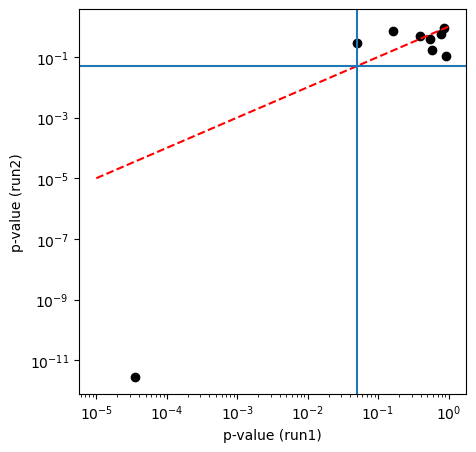

In [24]:
IEI = InputEdgeInferrer(model, data, x_train, y_train)
res2 = IEI.infer(**iei_kwargs)

plt.figure(figsize=(5, 5))
plt.plot(res['pval'], res2['pval'], 'ko')
plt.plot([1e-5, 1], [1e-5, 1], 'r--')
plt.xlabel('p-value (run1)')
plt.ylabel('p-value (run2)')
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.05)
plt.axhline(0.05)
plt.show()